In [1]:
import os
os.chdir('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

In [ ]:
df_train = pd.read_csv('data/clean/clean_data_train.csv', index_col=False) ## Use large dataset to train nn

df_train['team1'] = df_train['team1'].map(lambda l: l.replace(' ', ''))
df_train['team2'] = df_train['team2'].map(lambda l: l.replace(' ', ''))

df_test = pd.read_csv('data/clean/clean_data_test.csv', index_col=False)

In [ ]:
df_train.head()


,team1,team1score,team2,team2score,match_type,match_stage,player0_id,player0_rating,player0_kd,player1_id,...,player7_kd,player8_id,player8_rating,player8_kd,player9_id,player9_rating,player9_kd,team1_Ranking,team2_Ranking,team_1_won
0,FaZe,0,Spirit,3,BO5,GF,9960.0,1.16,1.14,11816.0,...,1.06,18317,1.07,1.04,7716.0,0.99,0.93,2.0,14.0,0
1,Spirit,2,Falcons,0,BO3,SF,21167.0,1.46,1.47,16920.0,...,1.05,11777,1.05,1.02,922.0,0.83,0.73,14.0,11.0,1
2,MOUZ,0,FaZe,2,BO3,SF,18850.0,1.13,1.23,13666.0,...,1.13,8183,1.11,1.02,429.0,0.94,0.83,5.0,2.0,0
3,ENCE,1,Falcons,2,BO3,QF,16848.0,1.20,1.36,19114.0,...,1.14,11777,1.07,1.05,922.0,0.86,0.76,48.0,11.0,0
4,FaZe,2,G2,0,BO3,QF,9960.0,1.16,1.17,11816.0,...,0.92,9618,0.96,0.89,10096.0,0.89,0.76,2.0,6.0,1


In [ ]:
### We will create embeddings for team Name and Player ID
team_name_list = pd.concat([df_train['team1'], df_train['team2'], df_test['team1'], df_test['team2']]).unique()

player_id_list = pd.concat([pd.concat([df_train[f'player{i}_id'], df_test[f'player{i}_id']]) for i in range(10)]).unique()


In [ ]:
from sklearn.preprocessing import LabelEncoder

team_name_enc = LabelEncoder()
team_name_enc.fit(team_name_list)
df_train['team1'] = team_name_enc.transform(df_train['team1'])
df_train['team2'] = team_name_enc.transform(df_train['team2'])


player_enc = LabelEncoder()
player_enc.fit(player_id_list)
for i in range(10):
    df_train[f'player{i}_id'] = player_enc.transform(df_train[f'player{i}_id'])

mt_enc = LabelEncoder()
mt_enc.fit(df_train['match_type'])
df_train['match_type'] = mt_enc.transform(df_train['match_type'])

ms_enc = LabelEncoder()
ms_enc.fit(df_train['match_stage'])
df_train['match_stage'] = ms_enc.transform(df_train['match_stage'])

In [ ]:
numerical_features = ['team1_Ranking', 'team2_Ranking']
for i in range(10):
    numerical_features.append(f'player{i}_rating')
    numerical_features.append(f'player{i}_kd')

text_features = ['team1', 'team2', 'match_type', 'match_stage']
for i in range(10):
    text_features.append(f'player{i}_id')

X_numerical = df_train[numerical_features]

X_text = df_train[text_features]

y = df_train['team_1_won']

In [ ]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(X_text, X_numerical, y, test_size=0.2, random_state=42)

X_text_train_list = []
for text_feat in text_features:
    X_text_train_list.append(X_text_train[text_feat])

X_text_val_list = []
for text_feat in text_features:
    X_text_val_list.append(X_text_val[text_feat])

In [ ]:
X_text_train

,team1,team2,match_type,match_stage,player0_id,player1_id,player2_id,player3_id,player4_id,player5_id,player6_id,player7_id,player8_id,player9_id
354,9,14,1,0,327,325,182,287,326,288,338,55,337,184
234,22,39,1,0,137,225,40,278,197,224,305,84,302,254
3,20,27,1,2,172,232,149,17,154,49,255,234,89,2
18,27,53,1,0,49,234,255,89,2,320,313,349,279,314
131,16,44,1,0,45,177,160,91,32,268,230,235,140,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,26,30,1,0,90,201,69,26,1,236,8,9,62,70
106,17,24,0,0,41,105,125,112,88,150,102,101,4,75
270,61,44,1,2,93,164,206,49,15,25,230,235,65,140
348,34,17,1,0,81,200,133,24,98,112,125,188,105,88


In [ ]:
from tensorflow.keras.layers import Dense, Embedding, BatchNormalization, ReLU, Concatenate, Flatten, Dropout
from tensorflow.keras.regularizers import L1L2, L2
from tensorflow.keras.activations import tanh
from tensorflow.keras import Input, Model

def get_model(layers = [64,64,64], rate = 0.5):
    input = Input(shape = (22, ))
    h = Dense(layers[0], kernel_regularizer=L1L2(1e-8, 1e-7), bias_regularizer=L2(1e-7))(input)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    for layer in layers[1:-2]:
        h = Dense(layer, kernel_regularizer=L1L2(1e-8, 1e-7), bias_regularizer=L2(1e-7))(h)
        h = BatchNormalization()(h)
        h = tanh(h)
        h = Dropout(rate)(h)
    h = Dense(layers[-1], kernel_regularizer=L1L2(1e-8, 1e-7), bias_regularizer=L2(1e-7))(h)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    output = Dense(1)(h) ## returns logits
    model = Model(inputs = input, outputs = output)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(loss = loss, optimizer = 'adam')
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


callback = EarlyStopping(patience = 200, restore_best_weights = True) ## 100 epoch patience for val loss


model = get_model([1024, 2048, 4096, 2048, 1024], rate= 0.2)
history = model.fit(X_numerical_train, y_train, epochs=10000, batch_size=64, validation_data=(X_numerical_val, y_val), verbose=False, callbacks=callback)

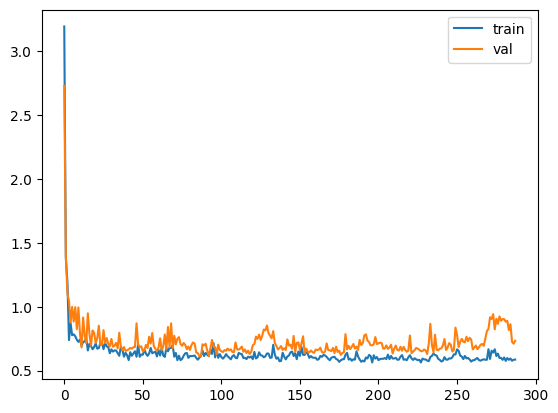

In [ ]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
# plt.ylim([0.4,1])
plt.legend()

In [ ]:
preds = model.predict(X_numerical_val)
print('accuracy is ', np.mean((preds>0).squeeze() == y_val))
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_val + np.log(1-probs)*(1-y_val)))


3/3 [==============================] - 0s 2ms/step
accuracy is  0.6790123456790124
Cross entropy score is  0.6093830764293671


In [ ]:
## Prepare test data
df_test['team1'] = df_test['team1'].map(lambda l: l.replace(' ', ''))
df_test['team2'] = df_test['team2'].map(lambda l: l.replace(' ', ''))

df_test['team1'] = team_name_enc.transform(df_train['team1'])
df_test['team2'] = team_name_enc.transform(df_train['team2'])

for i in range(10):
    df_test[f'player{i}_id'] = player_enc.transform(df_test[f'player{i}_id'])

df_test['match_type'] = mt_enc.transform(df_test['match_type'])

df_test['match_stage'] = ms_enc.transform(df_test['match_stage'])

df_num_test = df_test[numerical_features]

df_text_test = df_test[text_features]

y_test = df_test['team_1_won']

ValueError: y contains previously unseen labels: 26

In [ ]:
### train and test performance for test model

model = get_model([1024, 2048, 4096, 2048, 1024], rate= 0.5)
history = model.fit(X_numerical, y, epochs=500, batch_size=64, verbose=False)


In [ ]:
### make predictions for test data
preds = model.predict(df_num_test)
print('accuracy is ', np.mean((preds>0).squeeze() == y_test))
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_test + np.log(1-probs)*(1-y_test)))

2/2 [==============================] - 0s 2ms/step
accuracy is  0.7647058823529411
Cross entropy score is  0.6057571133269983


In [ ]:
def get_full_model(embed_dim=32, layer_dims = [64, 64, 64], rate = 0.2):
    team_embedding = Embedding(len(team_name_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))
    player_embedding = Embedding(len(player_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))
    match_type_embedding = Embedding(len(mt_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))
    match_stage_embedding = Embedding(len(ms_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))

    ## get inputs for each text feature
    t1 = Input(shape = (1))
    t2 = Input(shape = (1))
    mt = Input(shape = (1))
    ms = Input(shape = (1))
    p0 = Input(shape=(1))
    p1 = Input(shape=(1))
    p2 = Input(shape=(1))
    p3 = Input(shape=(1))
    p4 = Input(shape=(1))
    p5 = Input(shape=(1))
    p6 = Input(shape=(1))
    p7 = Input(shape=(1))
    p8 = Input(shape=(1))
    p9 = Input(shape=(1))

    ## Embed each text feature
    t1_embed = Flatten()(team_embedding(t1))
    t2_embed = Flatten()(team_embedding(t2))
    mt_embed = Flatten()(match_type_embedding(mt))
    ms_embed = Flatten()(match_stage_embedding(ms))
    p0_embed = Flatten()(player_embedding(p0))
    p1_embed = Flatten()(player_embedding(p1))
    p2_embed = Flatten()(player_embedding(p2))
    p3_embed = Flatten()(player_embedding(p3))
    p4_embed = Flatten()(player_embedding(p4))
    p5_embed = Flatten()(player_embedding(p5))
    p6_embed = Flatten()(player_embedding(p6))
    p7_embed = Flatten()(player_embedding(p7))
    p8_embed = Flatten()(player_embedding(p8))
    p9_embed = Flatten()(player_embedding(p9))

    
    numerical_input = Input(shape = (22))

    ## Concatenate all features
    embeddings_concat = Concatenate()([t1_embed, t2_embed, mt_embed, ms_embed, p0_embed, p1_embed, p2_embed, p3_embed, p4_embed, p5_embed, p6_embed, p7_embed, p8_embed, p9_embed, numerical_input])
    # embeddings_concat = Concatenate()([t1_embed, t2_embed, mt_embed, ms_embed, numerical_input])

    h = Dense(layer_dims[0], kernel_regularizer=L1L2(1e-5, 1e-5), bias_regularizer=L2(1e-5))(embeddings_concat)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    for layer in layer_dims[1:-2]:
        h = Dense(layer, kernel_regularizer=L1L2(1e-5, 1e-5), bias_regularizer=L2(1e-5))(h)
        h = BatchNormalization()(h)
        h = tanh(h) 
        h = Dropout(rate)(h)

    h = Dense(layer_dims[-1], kernel_regularizer=L1L2(1e-5, 1e-5), bias_regularizer=L2(1e-5))(h)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    output = Dense(1)(h)

    model = Model(inputs = (t1, t2, mt, ms, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, numerical_input), outputs = output)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(loss = loss, optimizer = 'adam')
    return model

In [ ]:
model = get_full_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [ ]:
callback = EarlyStopping(patience = 200, restore_best_weights = True) ## 100 epoch patience for val loss

X_train_concat = [X_text_train_list[i] for i in range(len(text_features))] + [X_numerical_train]
X_val_concat = [X_text_val_list[i] for i in range(len(text_features))] + [X_numerical_val]

model = get_full_model(16, [8192, 8192, 8192], rate=0.2)
history = model.fit(X_train_concat, y_train, epochs=2500, batch_size=64, validation_data=(X_val_concat, y_val), verbose=False, callbacks= callback)

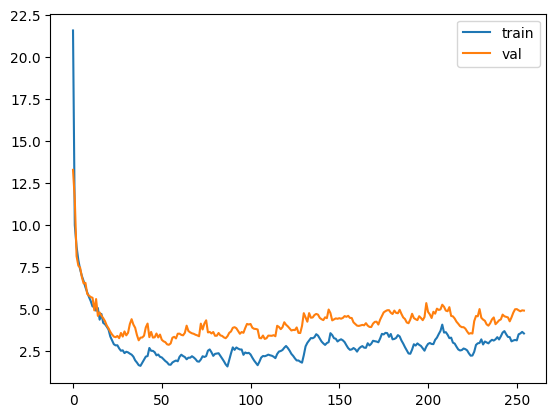

In [ ]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
# plt.ylim([0,3])
plt.legend()

In [ ]:
preds = model.predict(X_val_concat)

print('accuracy is ', np.mean((preds>0.5).squeeze() == y_val))
binCE_loss = tf.keras.losses.binary_crossentropy(y_val, preds)
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_val + np.log(1-probs)*(1-y_val)))


3/3 [==============================] - 0s 4ms/step
accuracy is  0.6172839506172839
Cross entropy score is  1.3170918798148503


In [ ]:
### train and test performance for test model
X_text_list = []
for text_feat in text_features:
    X_text_list.append(X_text[text_feat])

X_concat = [X_text_list[i] for i in range(len(text_features))] + [X_numerical]


model = get_full_model(16, [8192, 8192, 8192], rate=0.2)

history = model.fit(X_concat, y, epochs=200, batch_size=64, verbose=False)

In [ ]:
X_text_list_for_preds = []
for text_feat in text_features:
    X_text_list_for_preds.append(df_text_test[text_feat])

X_concat_for_pred = [X_text_list_for_preds[i] for i in range(len(text_features))] + [df_num_test]


### make predictions for test data
preds = model.predict(X_concat_for_pred)
print('accuracy is ', np.mean((preds>0).squeeze() == y_test))
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_test + np.log(1-probs)*(1-y_test)))

UnimplementedError: Graph execution error:

Detected at node 'model_4/Cast' defined at (most recent call last):
    File "C:\Users\Joe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Joe\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Joe\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\Joe\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\Joe\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Joe\AppData\Local\Temp\ipykernel_8884\2994126106.py", line 9, in <module>
      preds = model.predict(X_concat_for_pred)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\functional.py", line 649, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "c:\Users\Joe\Desktop\Term-2\Data_Science\DS_CW_2\.venv\lib\site-packages\keras\engine\functional.py", line 761, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model_4/Cast'
Cast string to float is not supported
	 [[{{node model_4/Cast}}]] [Op:__inference_predict_function_49198]

In [ ]:
df_text_test

,team1,team2,match_type,match_stage,player0_id,player1_id,player2_id,player3_id,player4_id,player5_id,player6_id,player7_id,player8_id,player9_id
0,Imperial,paiN,1,1,54,33,341,269,111,204,247,290,261,336
1,paiN,MIBR,1,4,204,247,290,261,336,305,84,224,254,302
2,Imperial,paiN,1,4,54,33,341,269,111,204,247,290,261,336
3,paiN,MIBR,0,3,204,247,290,261,336,305,84,302,224,254
4,Imperial,9z,0,3,54,33,341,269,111,311,138,343,100,292
5,Imperial,Metizport,0,2,54,33,269,341,111,266,298,307,156,128
6,Monte,paiN,0,2,174,251,329,274,309,204,290,247,336,261
7,MOUZ,FaZe,1,1,226,127,202,277,170,69,201,90,26,1
8,Astralis,FaZe,1,3,81,19,276,166,200,69,201,90,26,1
9,MOUZ,G2,1,3,226,127,202,277,170,236,8,9,62,70
